In [1]:
import torch
from torch.utils.data import Dataset
import time

# Visualization

In [2]:
import open3d as o3d

def makeO3Dpc(points):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points.numpy())
    return pcd

def visualize_pointcloud(pcd):
    if not isinstance(pcd, o3d.geometry.PointCloud):
        pcd = makeO3Dpc(pcd)
    o3d.visualization.draw_geometries([pcd])

# Reading data 

In [3]:
def parse_point_cloud(fname):
    
    points = []
    
    with open(fname) as f:
        for line in f.readlines():
            point = torch.Tensor(list(map(float, line.split(","))))
            points.append(point)
            
    return torch.stack(points)

In [4]:
filename = "/home/ioannis/Desktop/programming/data/SHREC/SHREC2022/dataset/training/pointCloud/pointCloud1.txt"
t1 = time.time()
for i in range(100):
    pcd = parse_point_cloud(filename)
print(f"Time to load 100 pointclouds: {time.time() - t1}")
visualize_pointcloud(pcd)

Time to load 100 pointclouds: 1.739661455154419


# Dataset

In [5]:
# Creating functions to parse the ground truth files

def parse_point_cloud(fpath):
    points = []
    
    with open(fpath) as f:
        for line in f.readlines():
            point = torch.Tensor(list(map(float, line.split(","))))
            points.append(point)
            
    return torch.stack(points)


def parse_plane(lines):
    normal = torch.Tensor(list(map(float, lines[1:4])))
    vertex = torch.Tensor(list(map(float, lines[4: ])))
    
    return {"type": 'plane', 
            "class": 0, 
            "normal": normal, 
            "vertex": vertex}

def parse_cylinder(lines):
    radius = float(lines[1])
    axis   = torch.Tensor(list(map(float, lines[2:5])))
    vertex = torch.Tensor(list(map(float, lines[5: ])))
    
    return {"type": 'cylinder', 
            "class": 1, 
            "radius": radius, 
            "axis": axis, 
            "vertex": vertex} # vertex on the cylinder axis
    
def parse_sphere(lines):
    radius = float(lines[1])
    center = torch.Tensor(list(map(float, lines[2: ])))
    
    return {"type": 'sphere', 
            "class": 2, 
            "radius": radius, 
            "center": center}
    
def parse_cone(lines):
    angle  = float(lines[1])
    axis   = torch.Tensor(list(map(float, lines[2:5])))
    vertex = torch.Tensor(list(map(float, lines[5: ])))
    
    return {"type": 'cone', 
            "class": 3, 
            "angle": angle, 
            "axis": axis, 
            "vertex": vertex} # vertex on the cone axis

def parse_torus(lines):
    major_radius = float(lines[1])
    minor_radius = float(lines[2])
    axis   = torch.Tensor(list(map(float, lines[3:6])))
    center = torch.Tensor(list(map(float, lines[6: ])))
    
    return {"type": 'torus',
            "class": 1,
            "major_radius": major_radius, 
            "minor_radius": minor_radius,
            "axis": axis, 
            "center": center}

# list containing the parsing functions
parse_fns = [parse_plane, parse_cylinder, parse_sphere, parse_cone, parse_torus]

def parse_ground_truth(fpath):
    
    with open(fpath) as f:
        # read the lines of the txt file
        context = f.readlines()
        
    fn_idx = int(context[0][0])
    parse_fn = parse_fns[fn_idx-1]
    
    label = parse_fn(context)
    
    return label
            

In [40]:
import torch
from torch.utils.data import Dataset
import os


class SHREC2022Primitives(Dataset):
    
    def __init__(self, path, train=True, transform=[]):
        
        # getting the path to the data
        self._path = os.path.join(path, "training" if train else "test")
        
        # directory hierarchy
        self._pc_folder = os.path.join(self._path, "pointCloud")
        self._gt_folder = os.path.join(self._path, "GTpointCloud")
        # file format
        self._format = ".txt"
        
        # getting the length of the dataset
        self._len = len(os.listdir(self._pc_folder)) 
        
        # storing the transforms to apply on the data
        self._transform = transform
        
        
    def __getitem__(self, index):
        
        # adding 1 because the files are not 0-indexed
        index += 1
        
        # assembling the names of the files (pointcloud and label)
        pc_path = os.path.join(self._pc_folder, "pointCloud"   + str(index) + self._format)
        gt_path = os.path.join(self._gt_folder, "GTpointCloud" + str(index) + self._format)
        
        # parsing the point cloud file
        pcd = parse_point_cloud(pc_path)
        
        # parsing the ground truth file
        gt = parse_ground_truth(gt_path)
        
        # assemble pcd and gt data in a single structure
        gt.update({"points": pcd})
        
        # pass that through the transforms
        for t in self._transform:
            gt = t(gt)
        
        return gt
        
        
    def __len__(self):
        return self._len

### Custom collate function

In [41]:
import MinkowskiEngine as ME

def custom_collate(list_data):
    
    coordinates, features, labels = ME.utils.sparse_collate(
        [d['points'] for d in list_data],
        [d['points'] for d in list_data],
        [d['class'] for d in list_data],
        dtype = torch.float32
    )

In [42]:
path = "/home/ioannis/Desktop/programming/data/SHREC/SHREC2022/dataset"
dataset = SHREC2022Primitives(path, train=True)
#visualize_pointcloud(dataset[0]["points"])

In [9]:
train_loader = torch.utils.data.DataLoader(dataset, 
                                           batch_size = 16, 
                                           shuffle=True, 
                                           collate_fn=custom_collate,
                                           num_workers=8)

In [43]:
from tqdm import tqdm
t1 = time.time()
for batch in tqdm(train_loader):
    pass
print(time.time() - t1)

 92%|█████████▏| 2634/2875 [01:39<00:09, 26.48it/s]


KeyboardInterrupt: 

# Data Visualization and Statistics

In [29]:
from collections import defaultdict
num_points = []


max_coord = defaultdict(list)
min_coord = defaultdict(list)

max_radius = []

for data in tqdm(dataset):
    points = data['points']
    
    num_points.append(len(points))
    
    max_coord['x'].append(points[:, 0].max())
    max_coord['y'].append(points[:, 1].max())
    max_coord['z'].append(points[:, 2].max())
    min_coord['x'].append(points[:, 0].min())
    min_coord['y'].append(points[:, 1].min())
    min_coord['z'].append(points[:, 2].min())
    
    point_dist = (points * points).sum(-1).sqrt()
    max_radius.append(point_dist.max())

100%|██████████| 46000/46000 [10:36<00:00, 72.25it/s] 


FileNotFoundError: [Errno 2] No such file or directory: '/home/ioannis/Desktop/programming/data/SHREC/SHREC2022/dataset/training/pointCloud/pointCloud46001.txt'

# Network


In [44]:
torch.max(torch.tensor(num_points))

tensor(8100)

In [49]:
torch.argmin(torch.tensor(num_points))

tensor(32004)

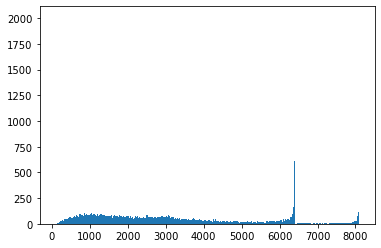

In [48]:
import matplotlib.pyplot as plt
plt.hist(num_points, bins=1000)
plt.show()

In [77]:
num_samples = 10
samples = torch.floor(torch.rand(num_samples) * 46000).long()
for idx in samples:
    t = dataset[idx.item()]["points"]
    points = points / (points * points).sum().max().sqrt()
    o3d_pc = makeO3Dpc(t)
    alpha = .5
    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(o3d_pc, alpha)
    mesh.compute_vertex_normals()
    o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)

In [58]:
print(torch.max(torch.tensor(max_coord['x'])))
print(torch.min(torch.tensor(min_coord['x'])))
print("-----------")
print(torch.max(torch.tensor(max_coord['y'])))
print(torch.min(torch.tensor(min_coord['y'])))
print("-----------")
print(torch.max(torch.tensor(max_coord['z'])))
print(torch.min(torch.tensor(min_coord['z'])))
print("-----------")
print(torch.max(torch.tensor(max_radius)))
print(torch.min(torch.tensor(max_radius)))

tensor(49.4140)
tensor(-29.2838)
-----------
tensor(48.0267)
tensor(-36.8616)
-----------
tensor(48.7960)
tensor(-29.9898)
-----------
tensor(66.7999)
tensor(0.4919)
